# CNNGeometric demo notebook (Tensorflow)
This notebook shows how to run a trained model on a given image pair

## Imports

In [14]:
import os
import argparse
import tensorflow as tf
from model.cnn_geometric_model import CNNGeometric
from data.pf_dataset import PFDataset
from data.download_datasets import download_PF_willow
from image.normalization import NormalizeImageDict, normalize_image
from util.tf_util import BatchTensorToVars, str_to_bool
from geotnf.transformation import GeometricTnf
from geotnf.point_tnf import *
import matplotlib.pyplot as plt
from skimage import io
import warnings
from collections import OrderedDict

warnings.filterwarnings('ignore')


## Parameters

In [15]:
feature_extraction_cnn = 'vgg'

if feature_extraction_cnn=='vgg':
    model_aff_path = 'trained_models/checkpoint_adam_affine_grid_loss_vgg_pascal_epoch_1.ckpt'
elif feature_extraction_cnn=='resnet101':
    model_aff_path = 'trained_models/best_pascal_checkpoint_adam_affine_grid_loss_resnet_random.pth.tar'

source_image_path='datasets/PF-dataset/duck(S)/060_0036.png'
target_image_path='datasets/PF-dataset/duck(S)/060_0013.png'

## Create image transformers

In [16]:
affTnf = GeometricTnf()

## Load and preprocess images

In [17]:
resizeCNN = GeometricTnf(out_h=240, out_w=240) 
#normalizeTnf = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

def preprocess_image(image):
    # convert to TF Variable
    image = np.expand_dims(image,0)
    image = np.array(np.float32(image)/255.0)
    image_var = np.array(image)
    
    # Resize image using bilinear sampling with identity affine tnf
    image_var = resizeCNN(image_var)
    
    # Normalize image
    image_var = normalize_image(image_var)
    
    return image_var

In [18]:
source_image = io.imread(source_image_path)
target_image = io.imread(target_image_path)

source_image_var = preprocess_image(source_image)
target_image_var = preprocess_image(target_image)

batch = {'source_image': source_image_var, 'target_image':target_image_var}

resizeTgt = GeometricTnf(out_h=target_image.shape[0], out_w=target_image.shape[1])

## Create & Evaluate model

In [19]:
# Evaluate models
with tf.Graph().as_default():
    # Create model
    print('Creating CNN model...')
    model_aff = CNNGeometric(feature_extraction_cnn=feature_extraction_cnn)
    theta_aff = model_aff(batch)
    init_op = tf.global_variables_initializer()
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(init_op)

        # Load trained weights
        print('Loading trained model weights...')
        saver.restore(sess,model_aff_path)
        # reload_checkpoint(sess, saver, args.model_aff)

        theta_aff = sess.run(theta_aff)
print('\nPredicted theta:', theta_aff)
warped_image_aff = affTnf(batch['source_image'], np.reshape(theta_aff, [-1, 2, 3]))

Creating CNN model...
Loading trained model weights...
INFO:tensorflow:Restoring parameters from trained_models/checkpoint_adam_affine_grid_loss_vgg_pascal_epoch_1.ckpt

Predicted theta: [[ 1.1005236  -0.00446203 -0.0449917   0.0391266   1.0590665   0.03016446]]


## Process result

In [20]:
# Un-normalize images and convert to numpy
warped_image_aff_np = normalize_image(warped_image_aff,forward=False)
warped_image_aff_np = resizeTgt(warped_image_aff_np)
warped_image_aff_np = np.squeeze(warped_image_aff_np, 0)

## Display

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


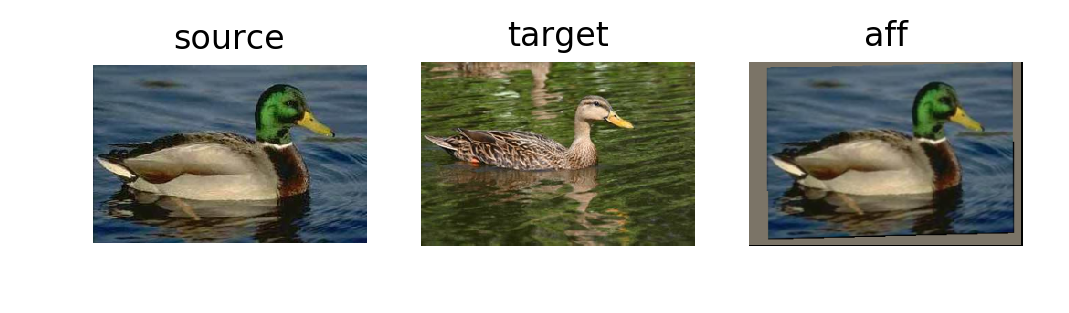

In [21]:
N_subplots =3
fig, axs = plt.subplots(1,N_subplots)
axs[0].imshow(source_image)
axs[0].set_title('source')
axs[1].imshow(target_image)
axs[1].set_title('target')
axs[2].imshow(warped_image_aff_np)
axs[2].set_title('aff')
subplot_idx = 3

for i in range(N_subplots):
    axs[i].axis('off')

fig.set_dpi(200)
plt.show()